Набор данных представляет собой информацию о лицах, которые в течение исследуемого периода попали или не попали в дефолт (допустили просроченную задолженность).Решаем задачу бинарной классификации.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, make_scorer



In [18]:
from google.colab import files
uploaded = files.upload()

Saving Training.xlsb to Training.xlsb


In [15]:
!pip install pyxlsb

Загрузка и просмотр данных. Данные полные(пропусков нет). В данных содержатся как категориальные, так и числовые столбцы

In [19]:
df = pd.read_excel('Training.xlsb')

df.reset_index(drop=True, inplace=True)
print(df.head())
print(df.info())

for column in df.columns:
    print(f'{column}: {df[column].unique()}')


   ID         A         B      C       D         E         F   G     H      I  \
0   1  0.198778  0.099389   0.00  799.90  1.777556  0.888778  13  3.49  Woman   
1   2  0.043000  0.021264  49.97  173.03  0.384511  0.190143  13  3.49  Woman   
2   3  0.067073  0.067073   0.00  329.90  0.599818  0.599818  13  3.49  Woman   
3   4  0.052700  0.052700   0.00  235.65  0.471300  0.471300  13  3.49  Woman   
4   5  0.141880  0.141880   0.00  634.45  1.268900  1.268900  13  3.49  Woman   

   ...       P          Q   R          S    T    U    V    W   X MARKER  
0  ...   2 Two   property  No      Works  Yes  Yes   No  Yes  No      0  
1  ...   2 Two  otherwise  No      Works  Yes  Yes  Yes  Yes  No      0  
2  ...   1 One   property  No  No couple   No  Yes   No  Yes  No      0  
3  ...  0 Zero   property  No  No couple  Yes  Yes  Few  Yes  No      0  
4  ...  0 Zero   property  No  No couple  Yes   No   No   No  No      0  

[5 rows x 26 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

Анализ целевой переменной MARKER

<ipython-input-5-6eb398a275dc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marker_percentages.index, y=marker_percentages.values, palette='viridis')


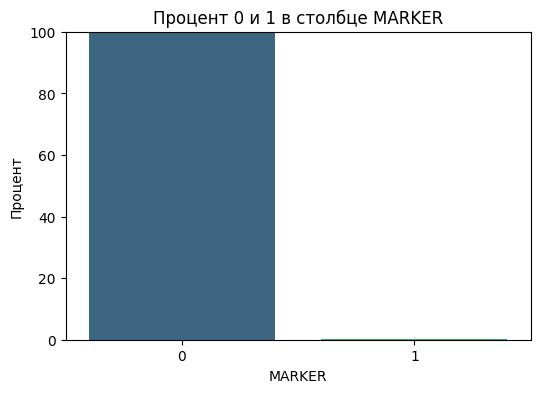

In [5]:
marker_counts = df['MARKER'].value_counts()
total_count = marker_counts.sum()
marker_percentages = (marker_counts / total_count) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=marker_percentages.index, y=marker_percentages.values, palette='viridis')
plt.title('Процент 0 и 1 в столбце MARKER')
plt.xlabel('MARKER')
plt.ylabel('Процент')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.ylim(0, 100)
plt.show()


Видно, что целевая переменная не сбалансирована, меньше одного процента данных класса 1, а остальное составляют данные класса 0

Создание копии датафрейма и разделение данных

In [20]:
df_transformed = df.copy()
X = df_transformed.drop(columns=['ID', 'MARKER'])
y = df_transformed['MARKER']

Исследование категориальный данных

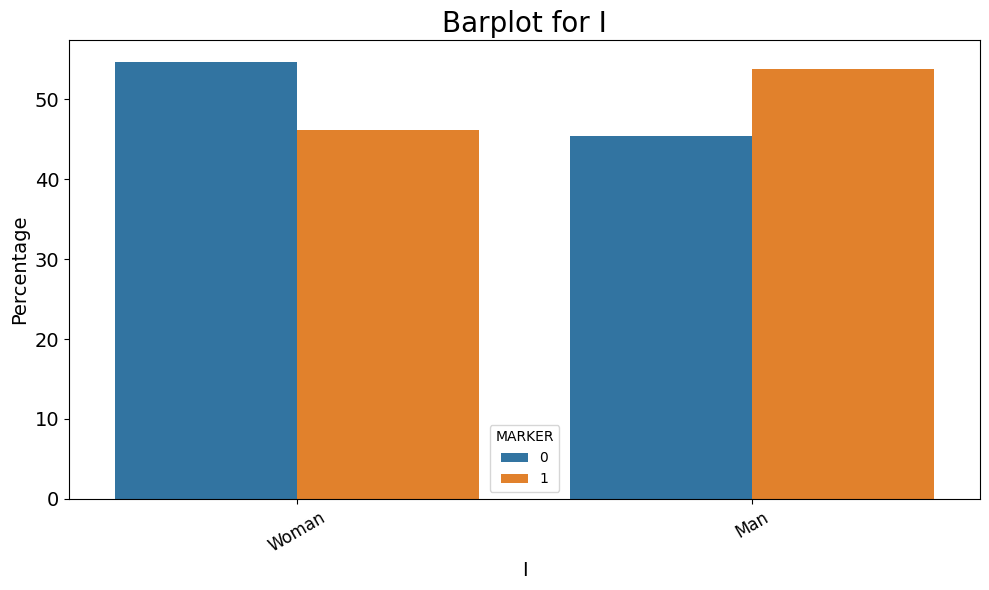

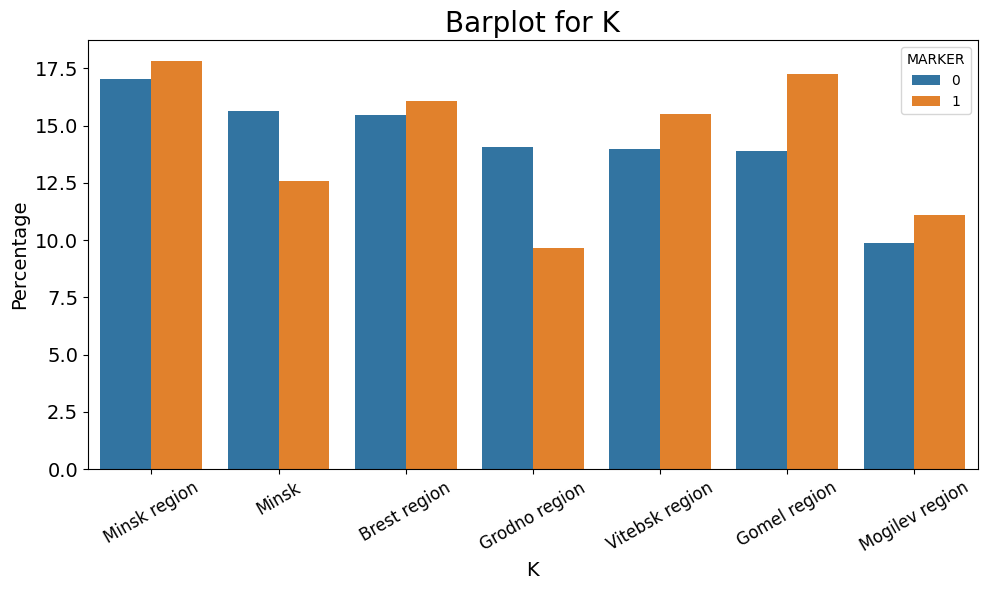

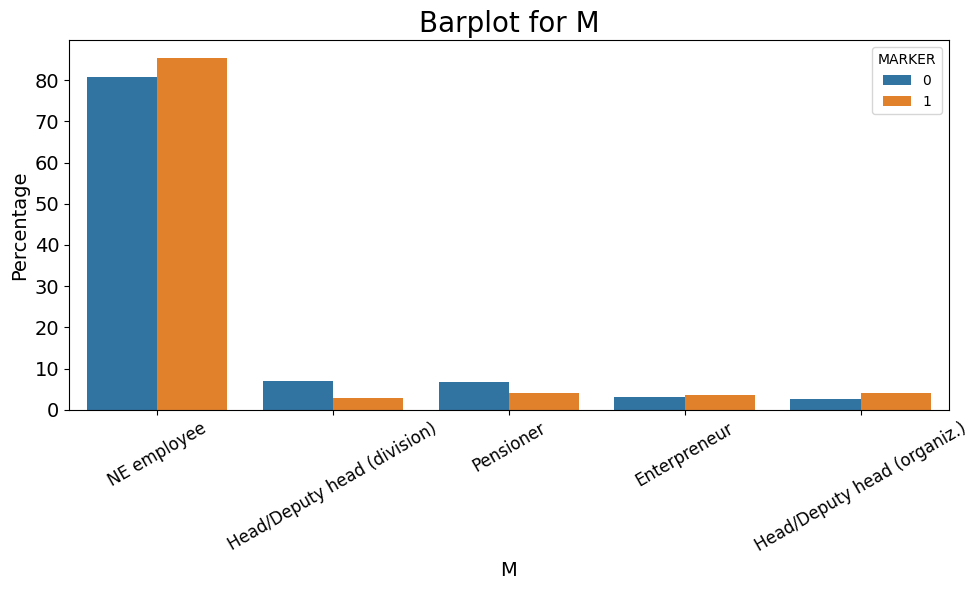

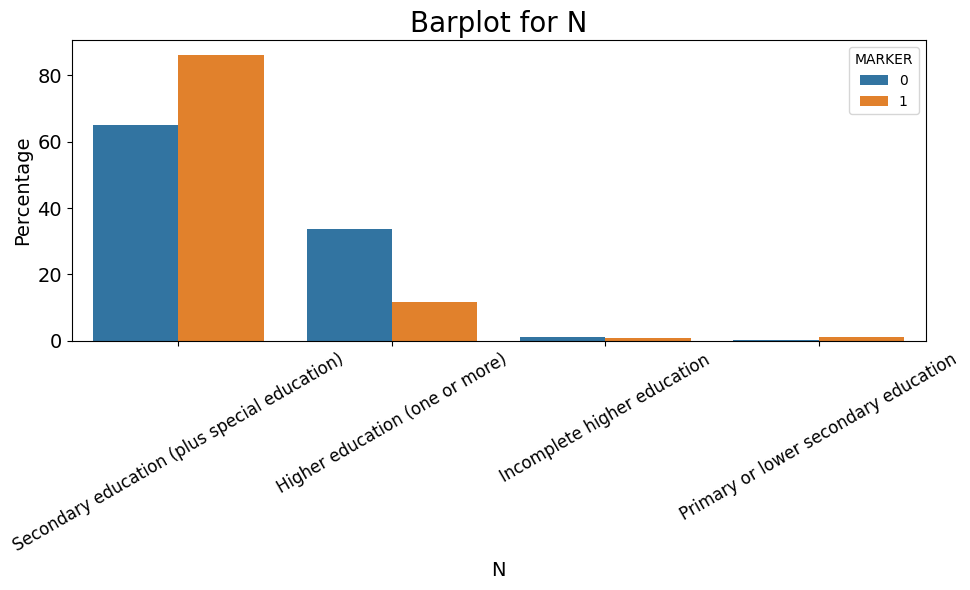

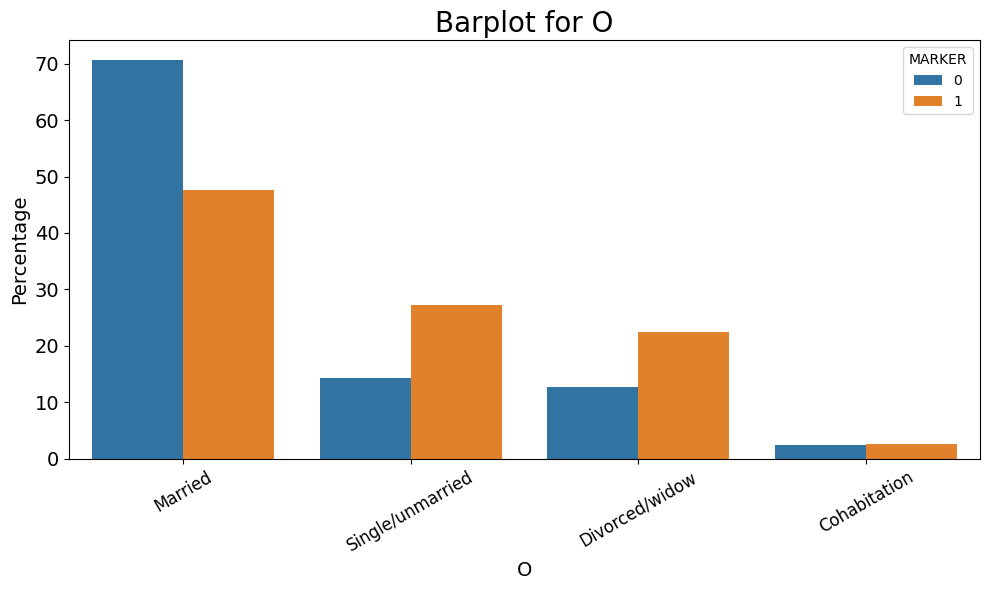

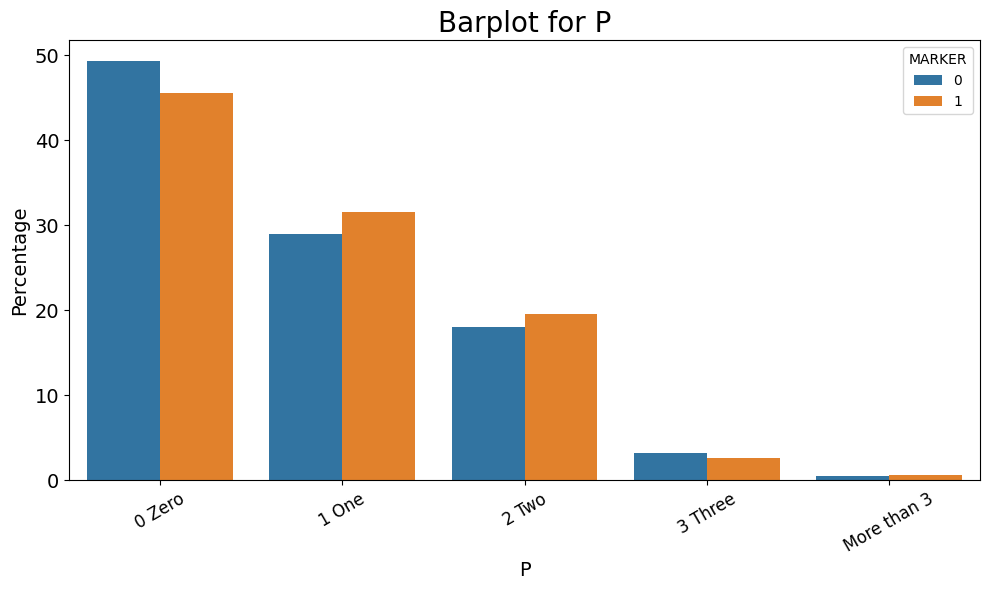

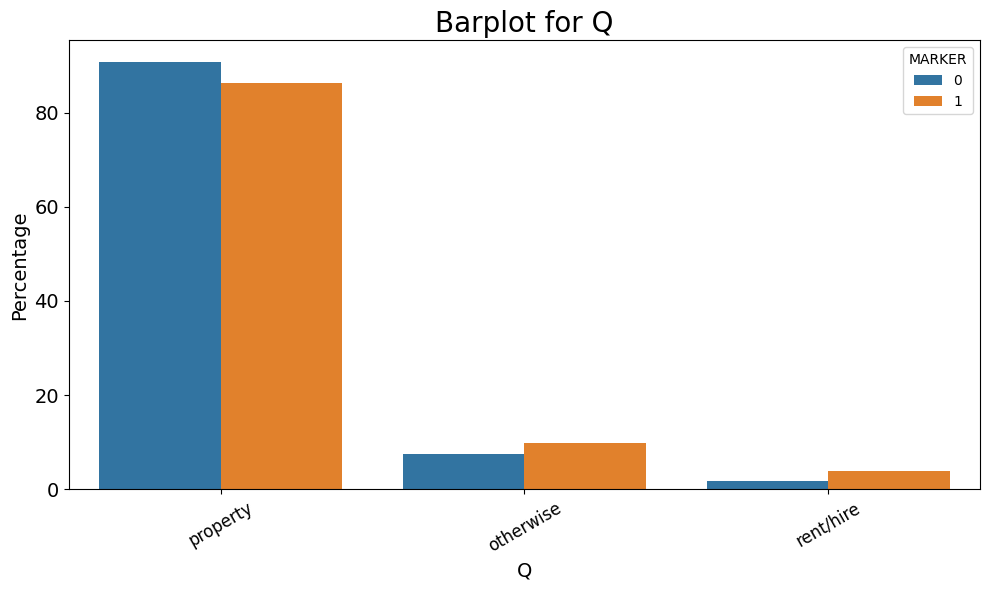

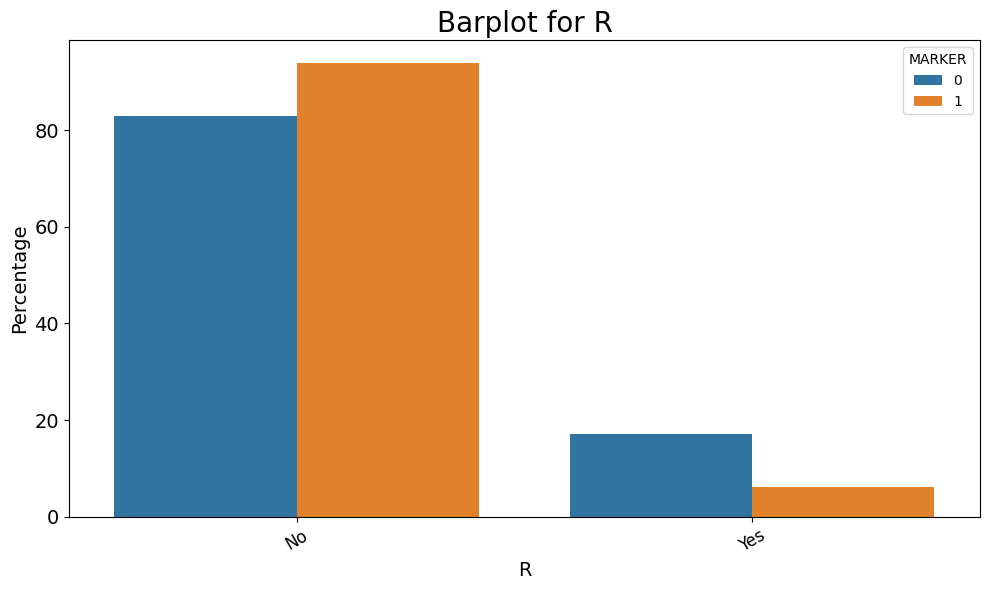

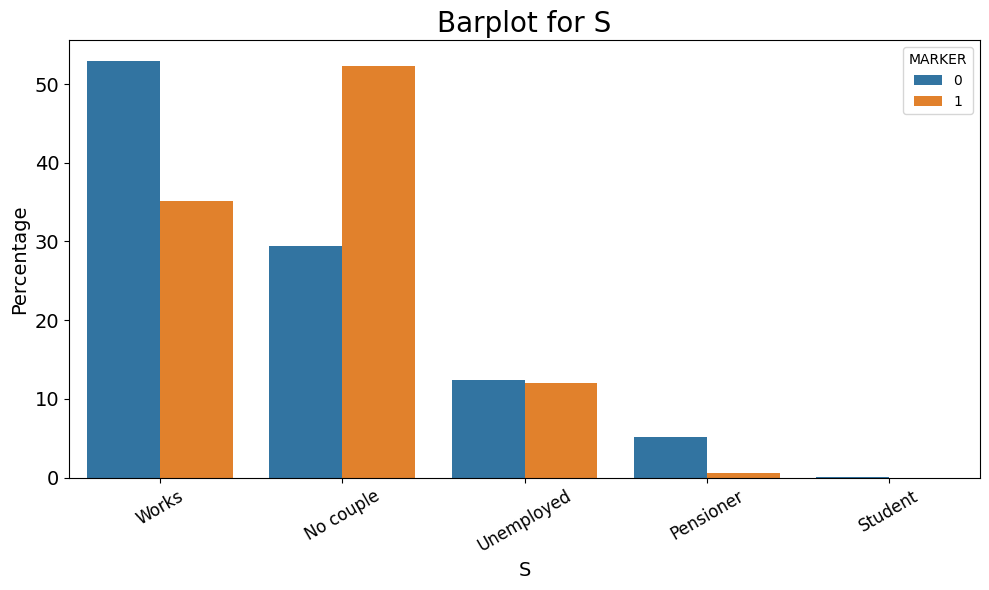

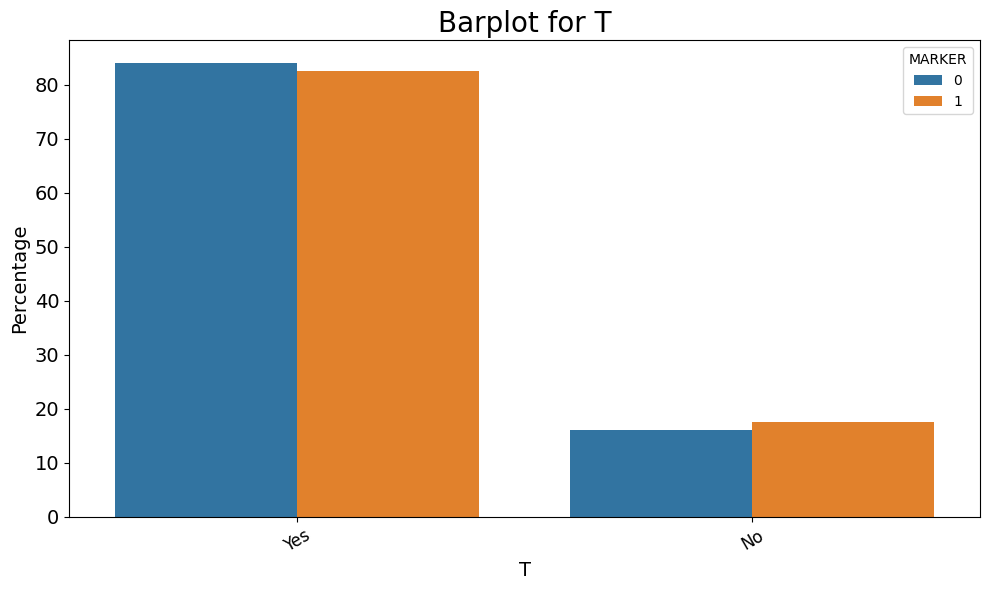

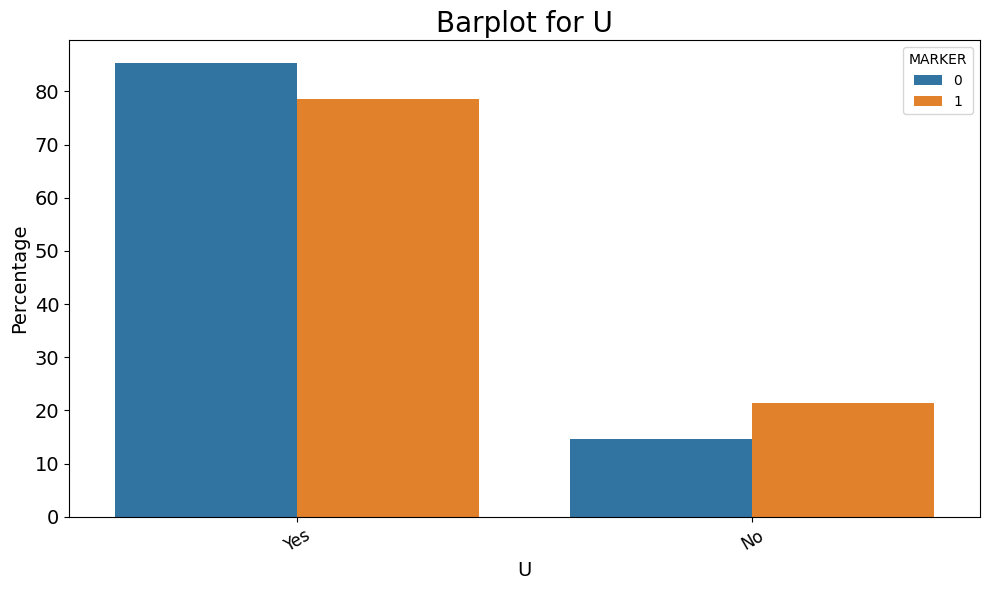

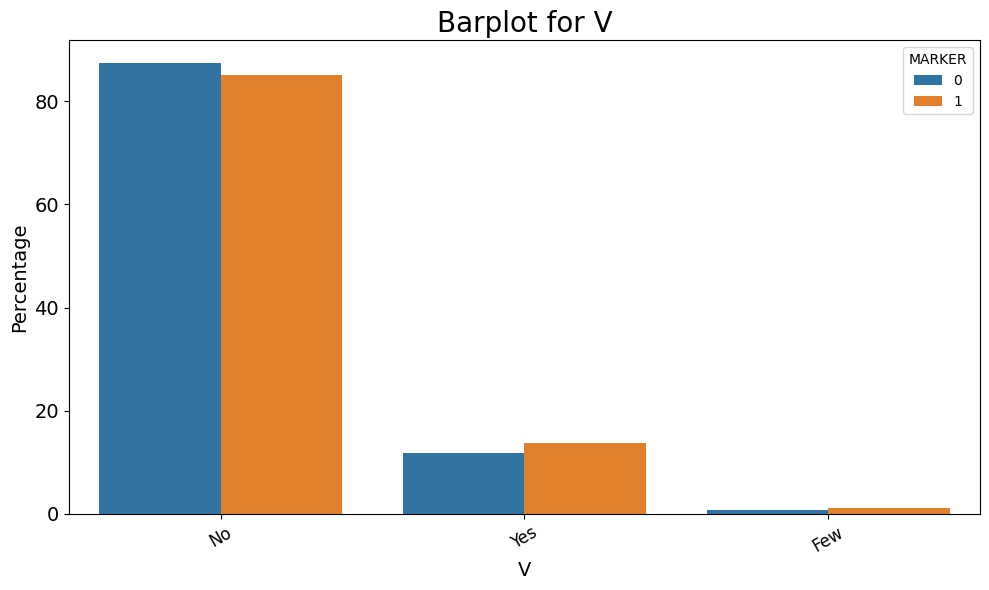

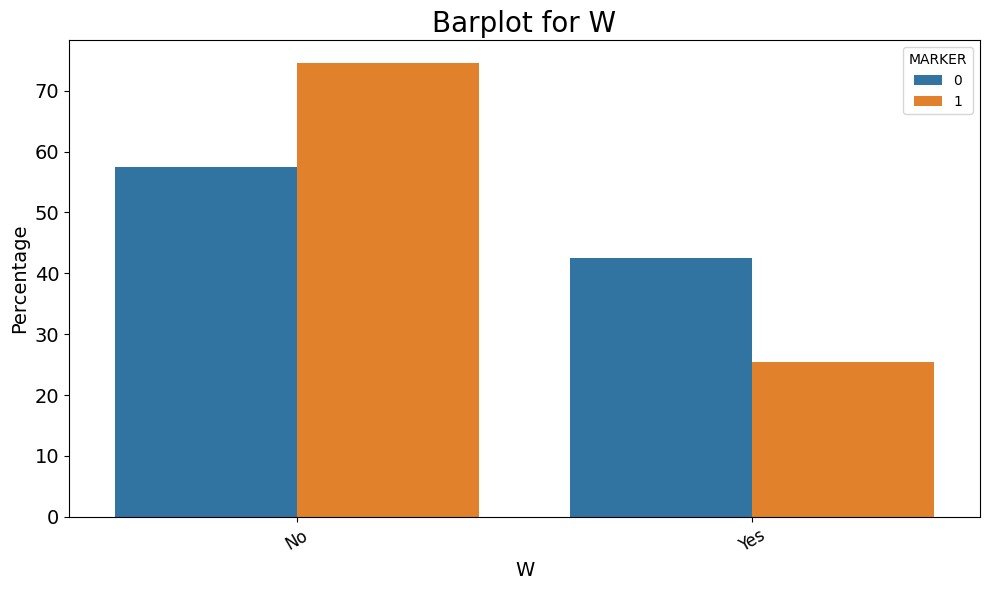

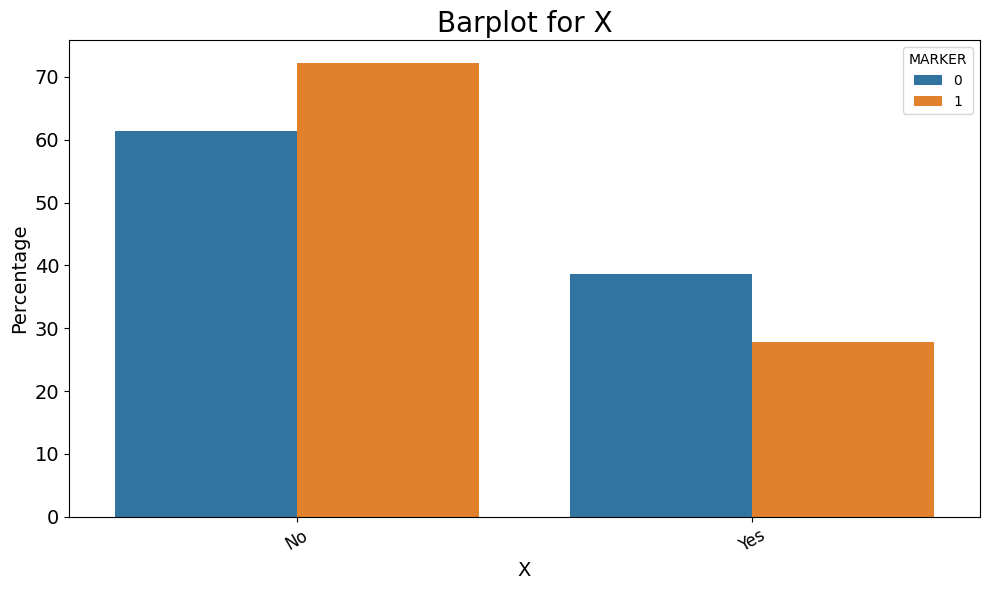

In [21]:
object_columns = X.select_dtypes(include=['object']).columns
for column in object_columns:

    o_def = (df.groupby("MARKER")[column]
             .value_counts(normalize=True)
             .rename("percent")
             .mul(100)
             .reset_index())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=column, y='percent', hue="MARKER", data=o_def)


    plt.title(f'Barplot for {column}', fontsize=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.xticks(rotation=30, fontsize=12)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

Кодирование катеориальных данных

In [22]:
for column in object_columns:
    labelencoder = LabelEncoder()
    df_transformed[column] = labelencoder.fit_transform(df_transformed[column])
df_transformed.head()

,ID,A,B,C,D,E,F,G,H,I,...,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,1,...,2,1,0,4,1,1,1,1,0,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,1,...,2,0,0,4,1,1,2,1,0,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,1,...,1,1,0,0,0,1,1,1,0,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,1,...,0,1,0,0,1,1,0,1,0,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,1,...,0,1,0,0,1,0,1,0,0,0


Разделение данных по классам целевой переменной

In [23]:
num_columns = X.select_dtypes(include=['float64']).columns

X_class_0 = df_transformed[df_transformed['MARKER'] == 0][num_columns]
X_class_1 = df_transformed[df_transformed['MARKER'] == 1][num_columns]

Работа с выбросами. При работе с выбросами с помощью квартилей в столбце Н получается слишком много выбросов(25%), поэтому в столбце Н работает с выбросами с помощью IsolationForest

In [24]:
def detect_outliers_iqr(data, threshold=2):
    outliers = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)].index.tolist()
    return outliers

outliers_class_0 = detect_outliers_iqr(X_class_0)
outliers_indices_st = set()
for column, indices in outliers_class_0.items():
    if column != 'H':
        outliers_indices_st.update(indices)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_pred = iso_forest.fit_predict(X_class_0[['H']])
outliers_indices_h = X_class_0.index[outliers_pred == -1]
outliers_indices_st.update(outliers_indices_h)

outliers_indices_st = list(outliers_indices_st)
df_transformed.drop(index=outliers_indices_st, inplace=True)
print(f"Изначальное количество данных в классе 0: {X_class_0.shape[0]}")
print(f"Количество данных в классе 0 после удаления выбросов: {df_transformed[df_transformed['MARKER'] == 0].shape[0]}")

Изначальное количество данных в классе 0: 89392
Количество данных в классе 0 после удаления выбросов: 75850


Визуализация данных до обработки

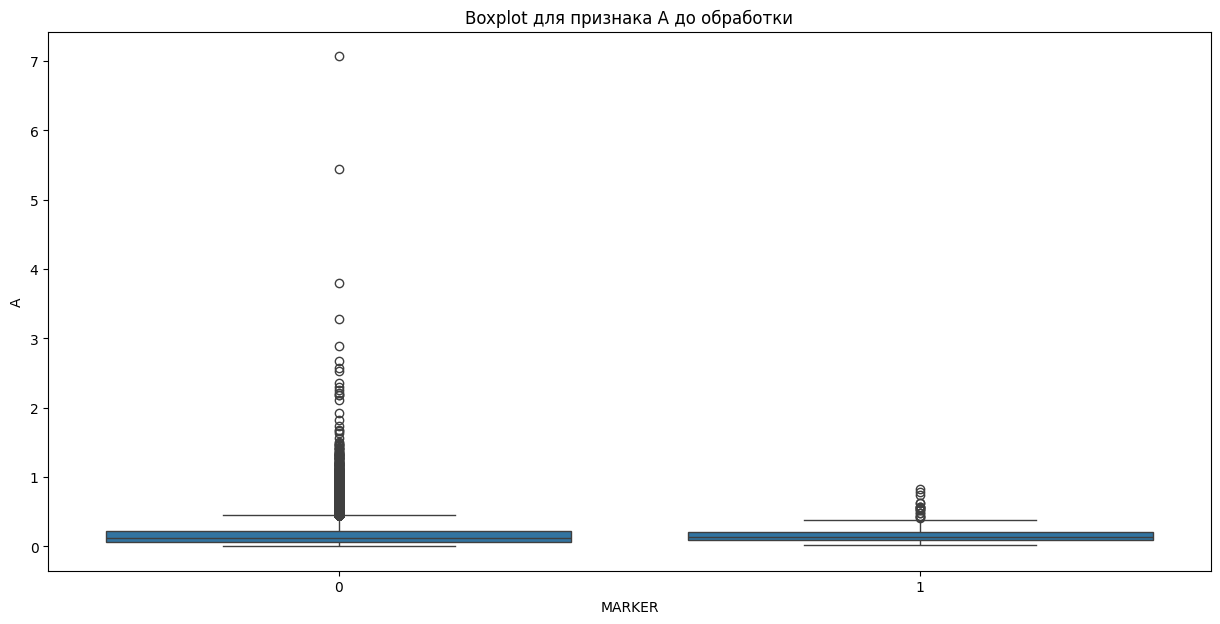

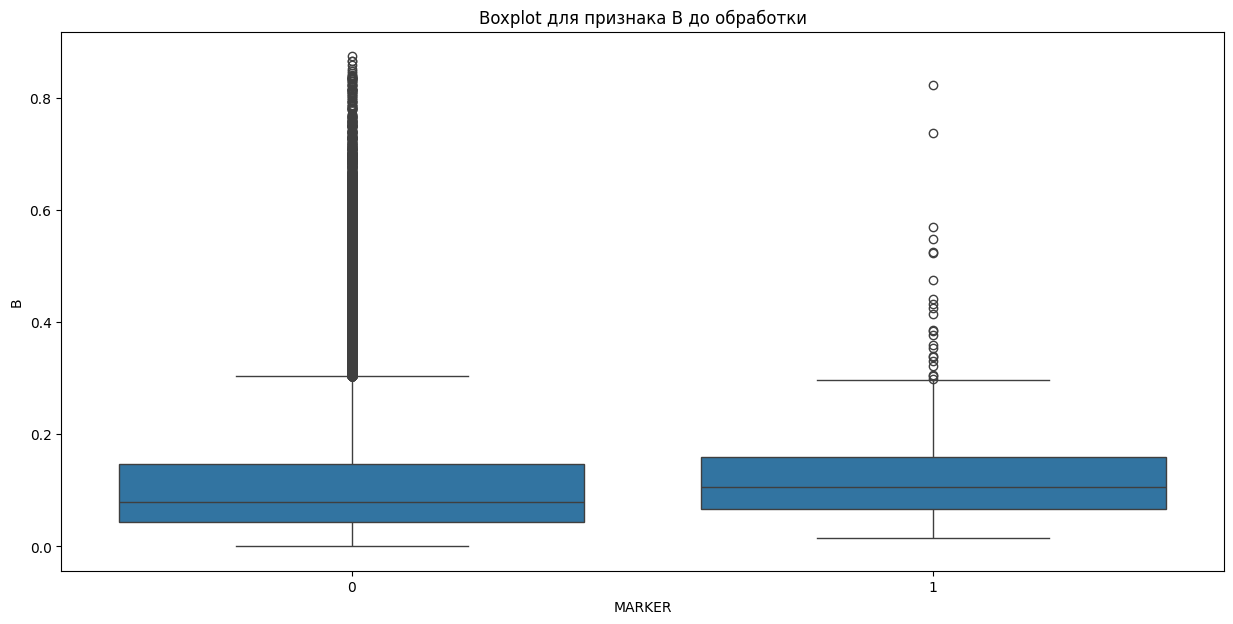

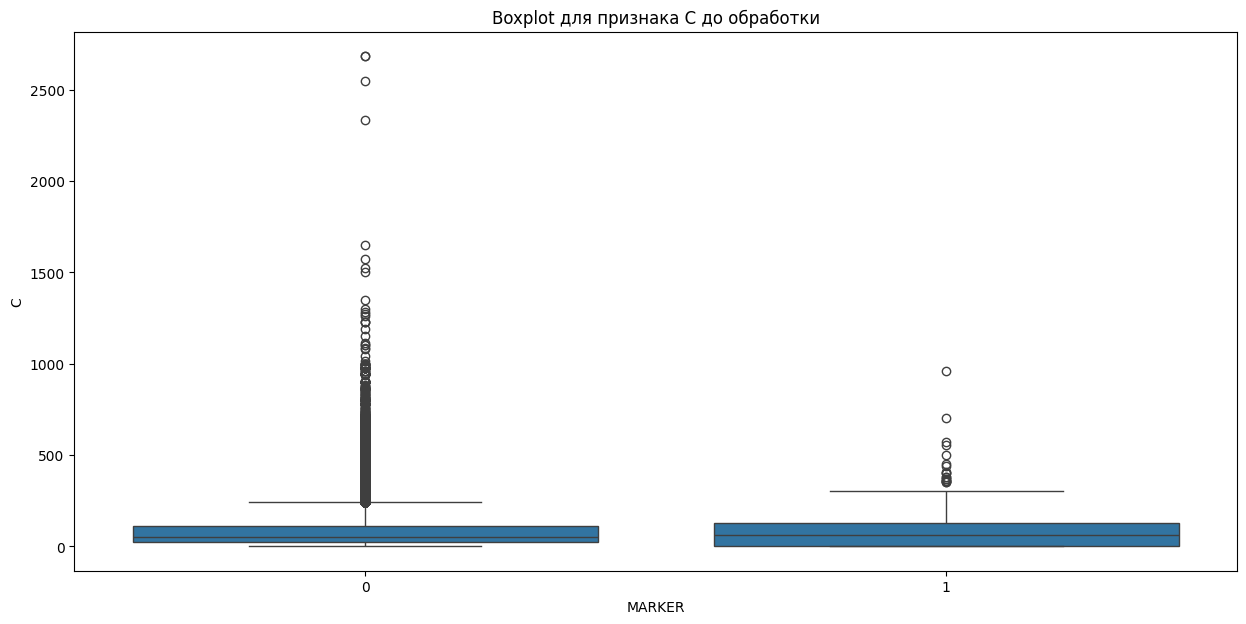

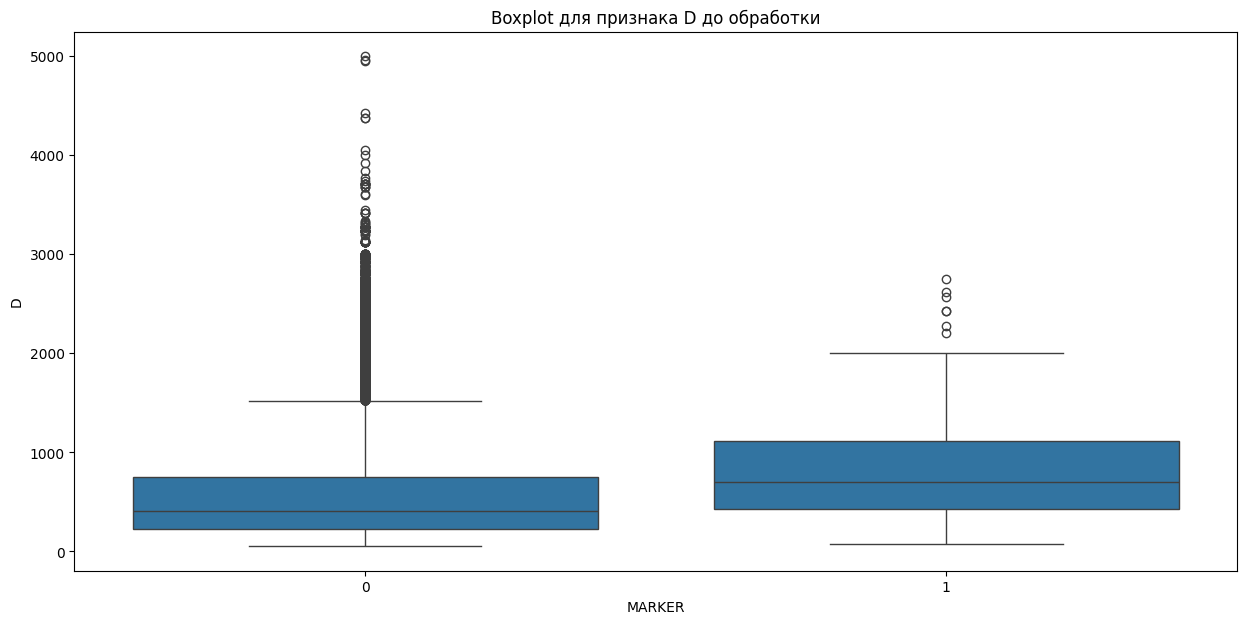

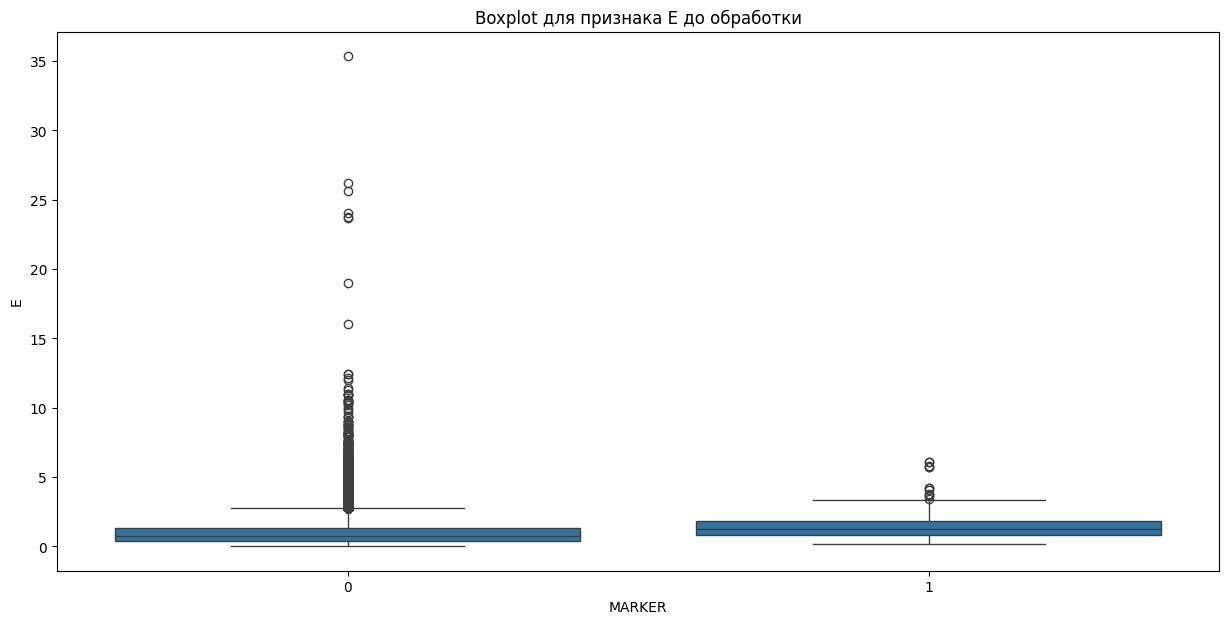

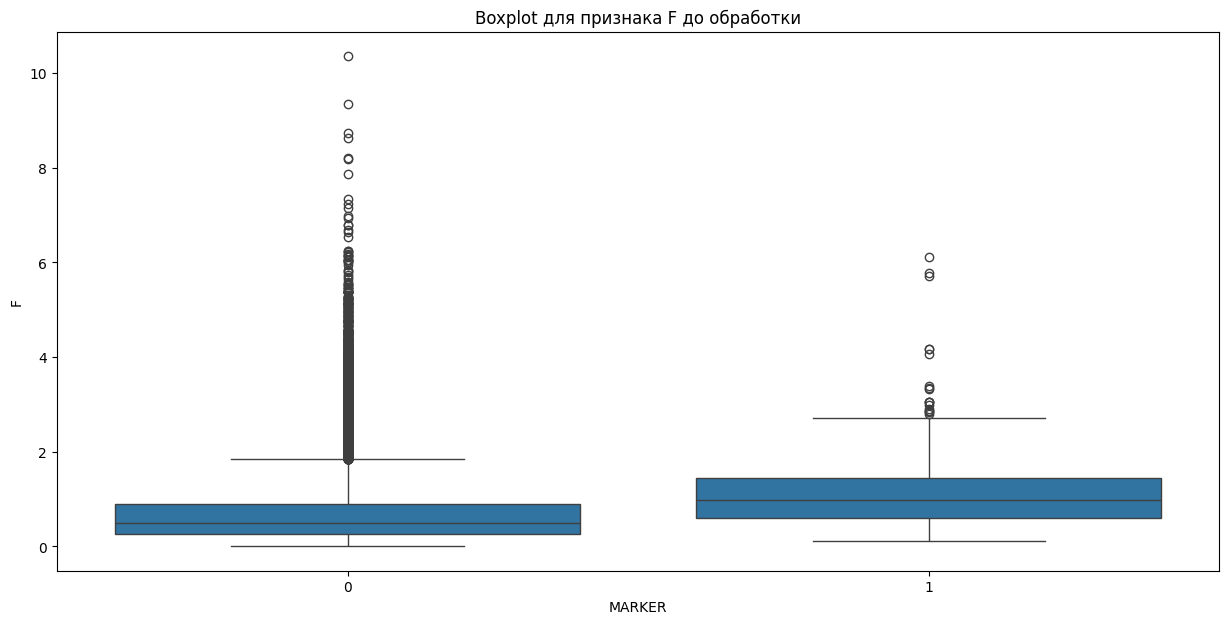

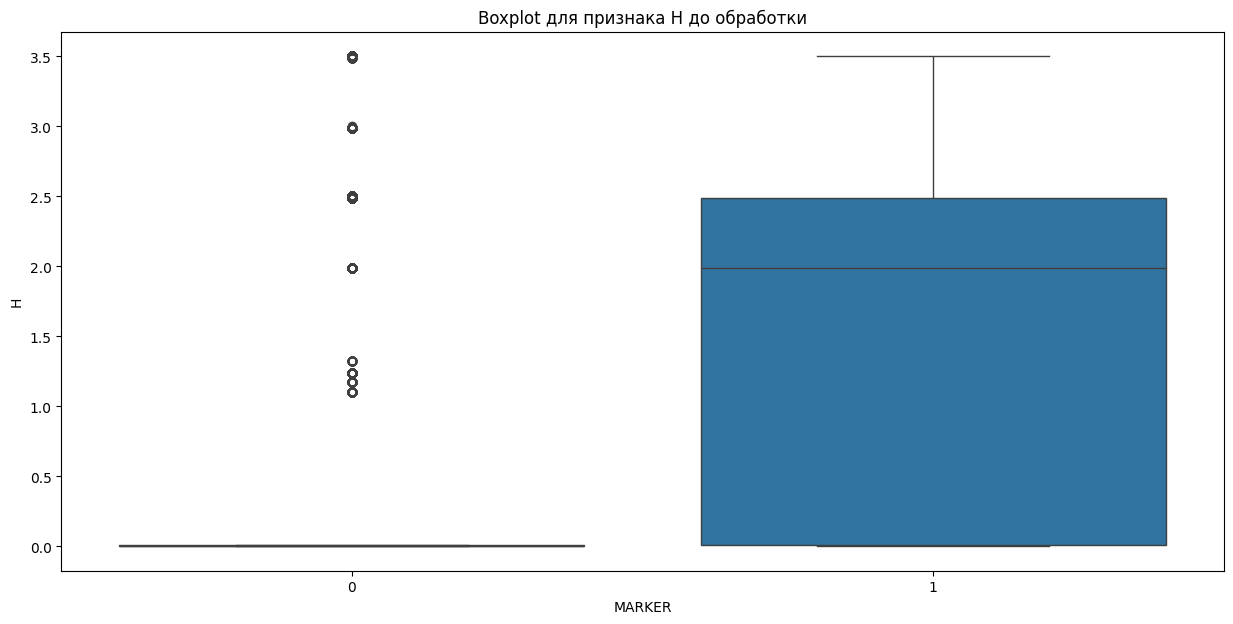

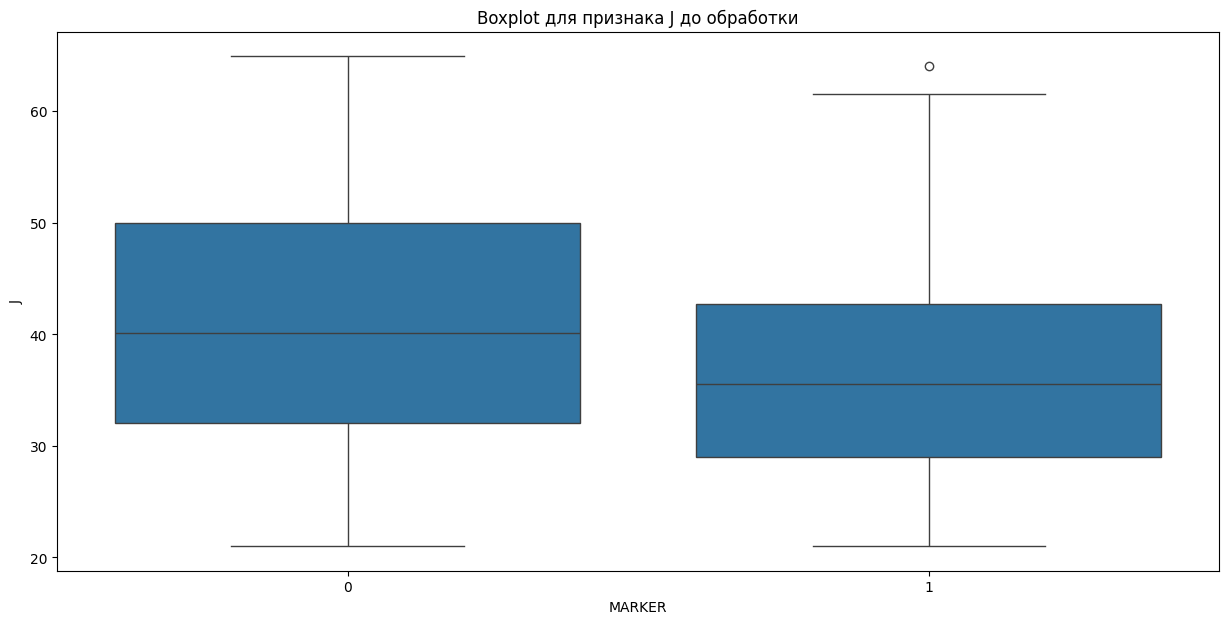

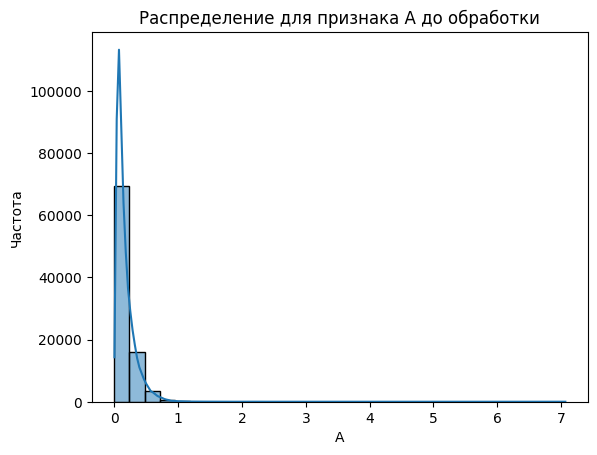

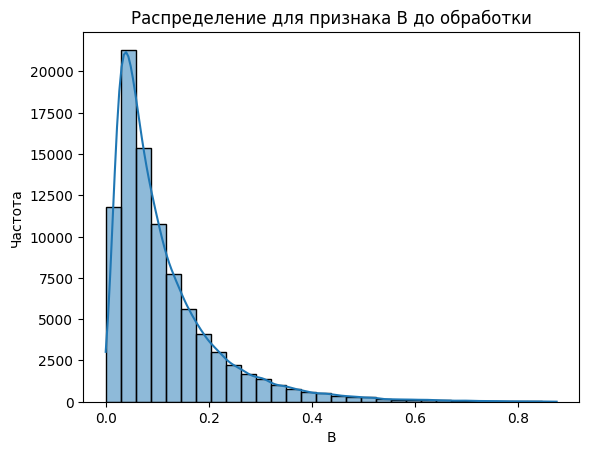

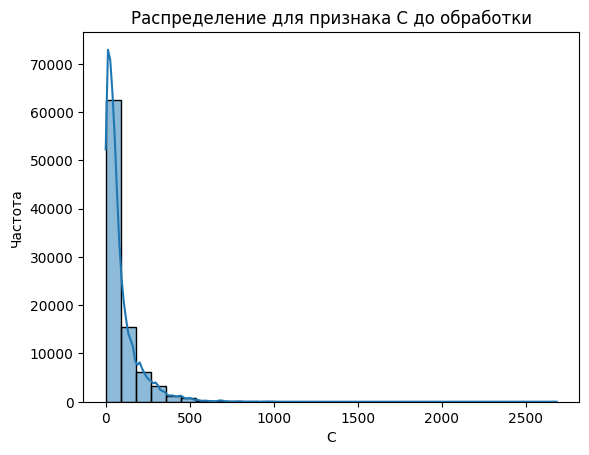

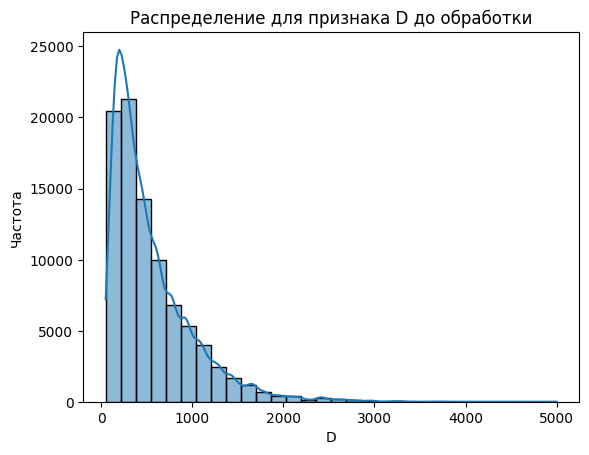

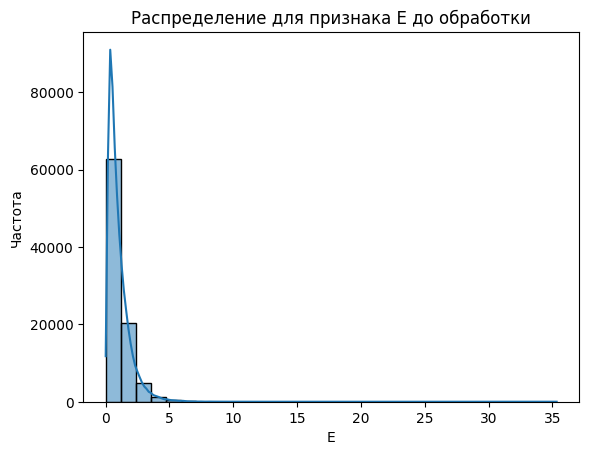

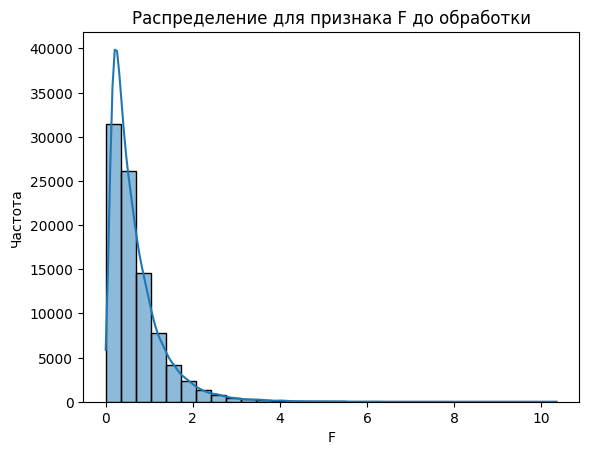

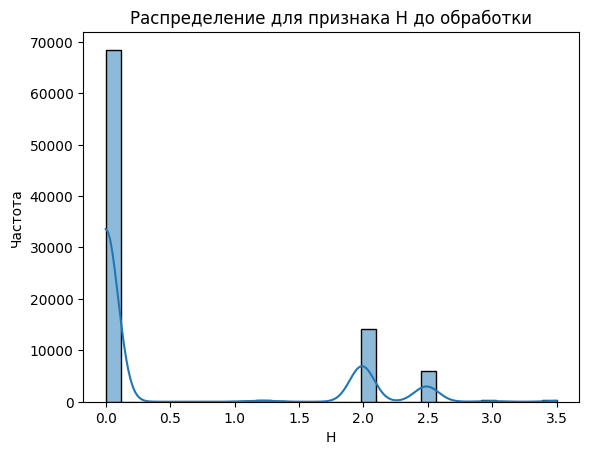

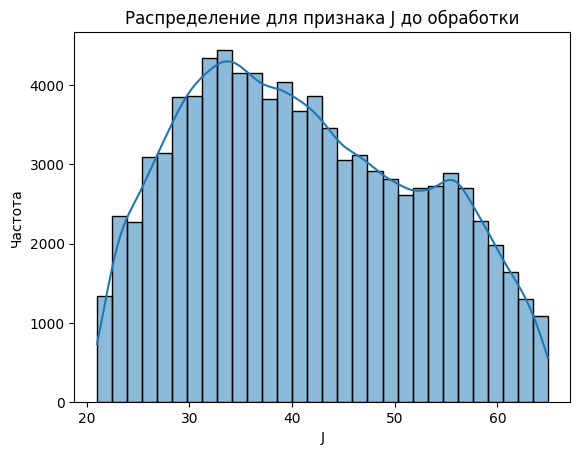

In [14]:
for column in num_columns:
    plt.figure(figsize=(15, 7))
    sns.boxplot(x="MARKER", y=column, data=df)
    plt.title(f"Boxplot для признака {column} до обработки")
    plt.xlabel("MARKER")
    plt.ylabel(column)
    plt.show()

for column in num_columns:
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение для признака {column} до обработки')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

В основном распределение данных похоже на экспоненциальное, поэтому для нормализации следует использовать логарифмическую трансформация или трансформация Йео-Джонсона, была проверена логарифмическая трансформация, но она показала себя хуже, поэтому была использована трансформация Йео-Джонсона. Также в столбцах G, H трансформация представлена пиками данных, ее преобразование к нормальному распределению не представляется возможным

Нормализация данных

In [25]:
pt = PowerTransformer(method='yeo-johnson')
for column in num_columns:
    if column not in ['G', 'H']:
        df_transformed[column] = pt.fit_transform(df_transformed[[column]])

df_transformed.head()

,ID,A,B,C,D,E,F,G,H,I,...,P,Q,R,S,T,U,V,W,X,MARKER
9,10,-0.459033,-0.550159,-1.873635,-0.626629,0.349904,0.228035,13,1.99,0,...,0,1,0,1,1,1,1,0,0,0
25,26,0.813614,-0.331053,-1.873635,1.518719,1.407470,0.265547,13,3.49,1,...,3,1,0,4,0,1,2,0,0,1
47,48,-0.468139,-0.622127,-1.873635,0.378805,0.262482,0.066244,13,2.49,1,...,0,1,0,1,1,1,2,1,0,0
48,49,0.393293,1.021391,-1.873635,0.948682,1.155792,1.694554,13,2.49,1,...,2,1,0,0,1,1,1,1,0,0
49,50,-0.624330,-0.784025,-1.873635,-0.341775,0.080511,-0.135514,13,2.49,0,...,1,0,0,0,1,0,2,1,0,0


Визуализация данных после обработки

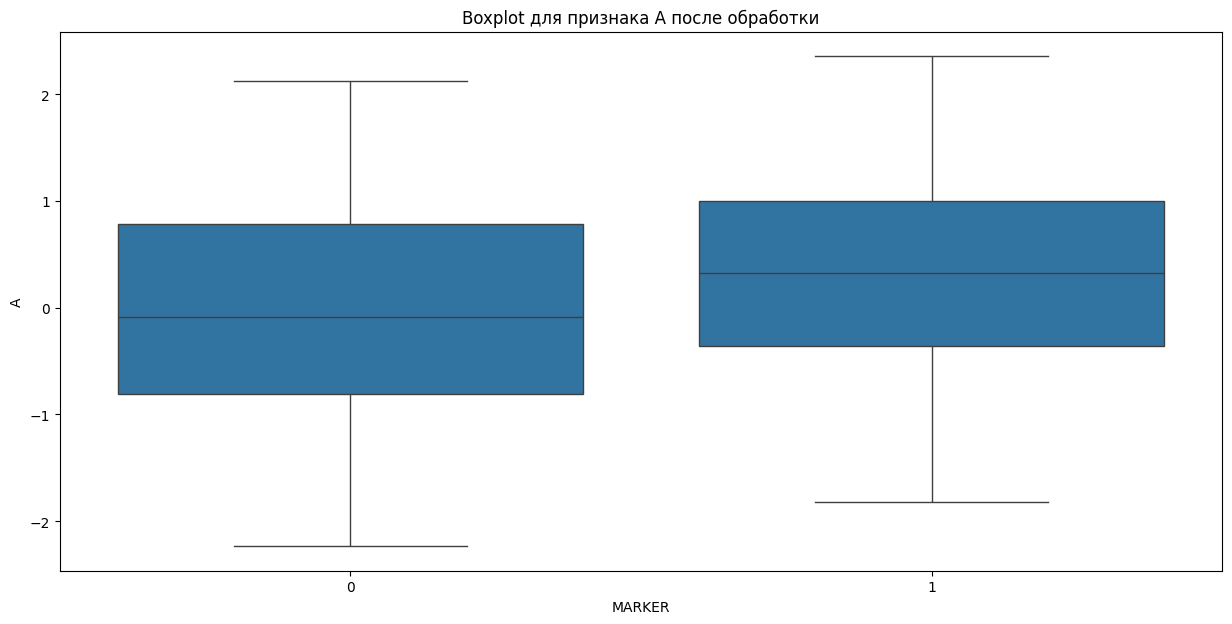

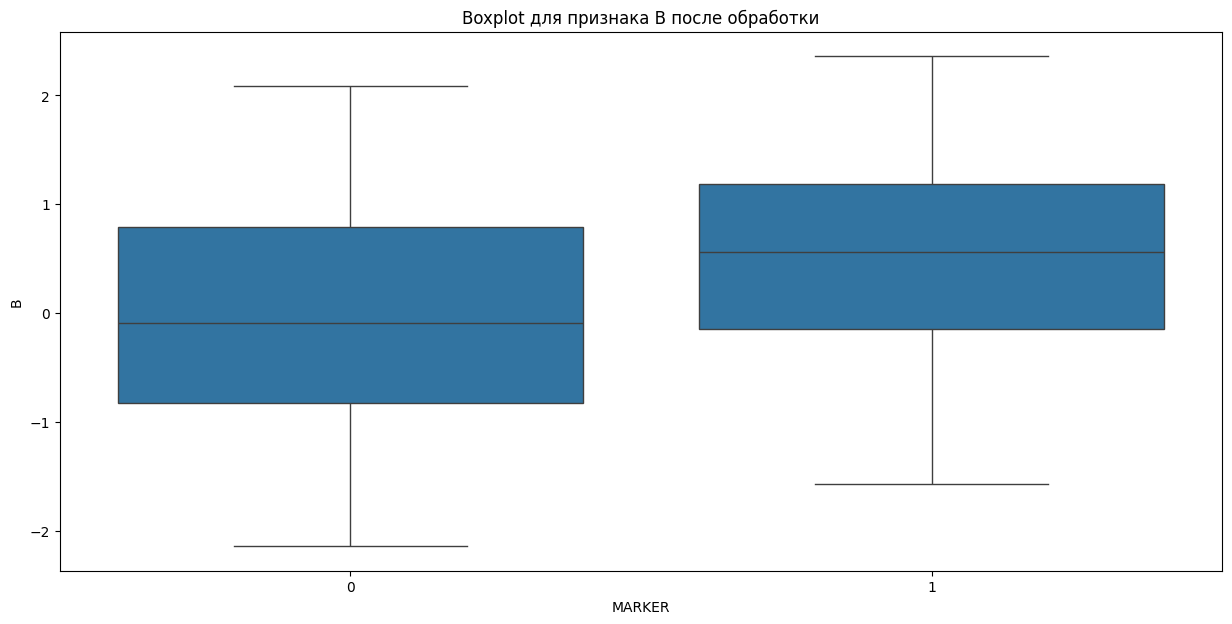

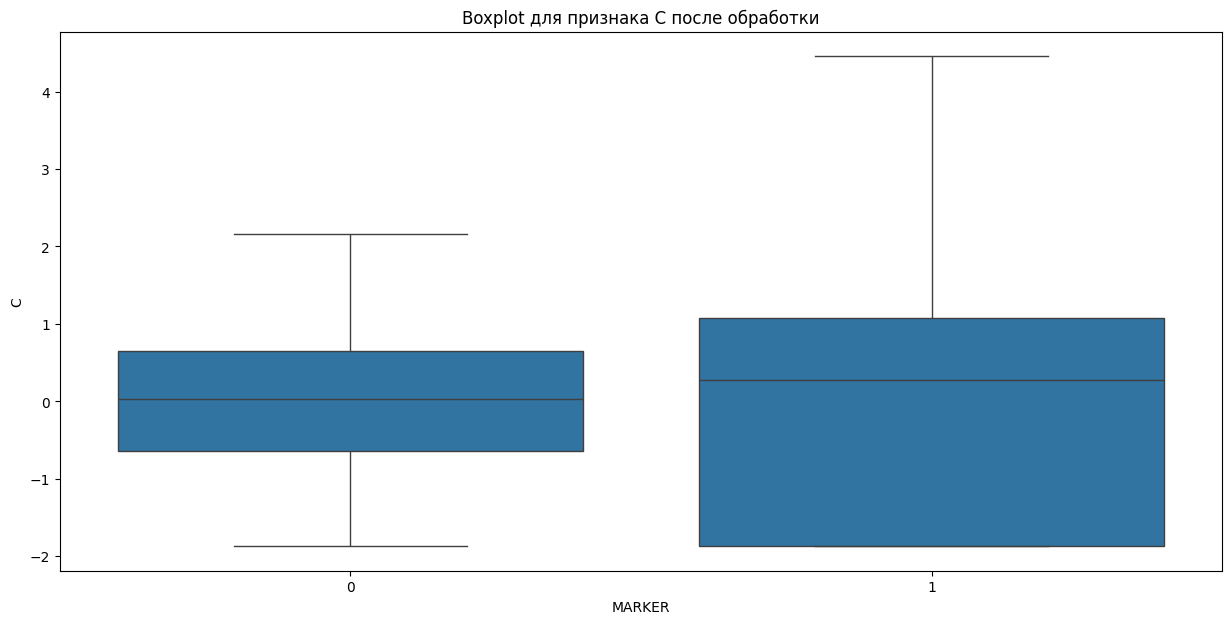

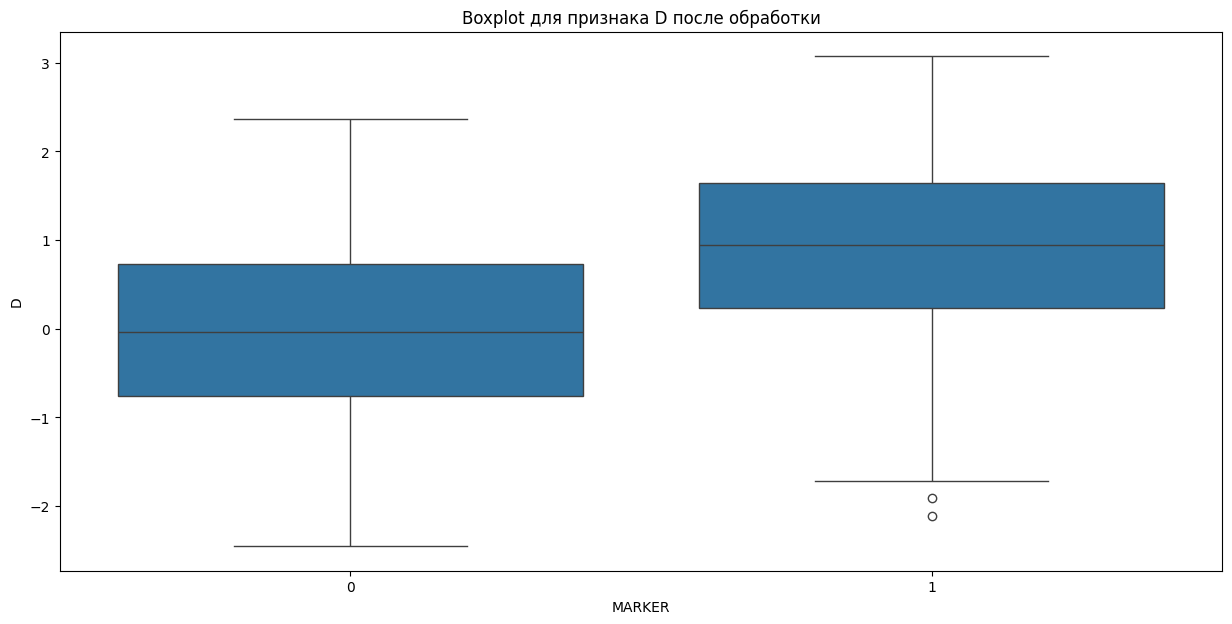

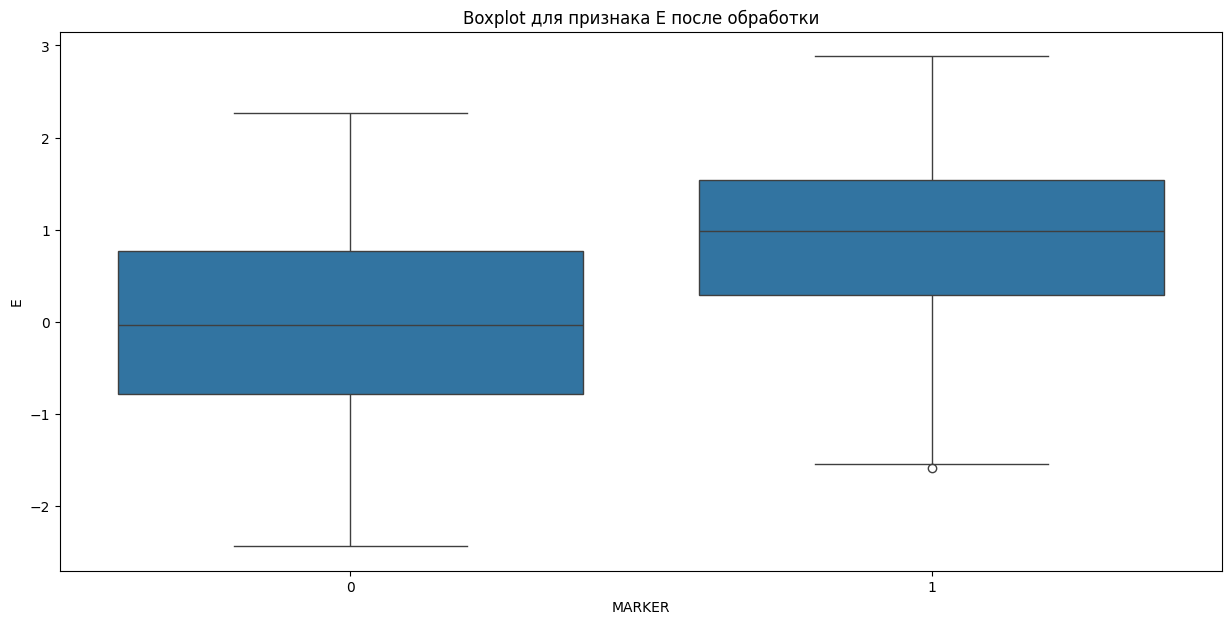

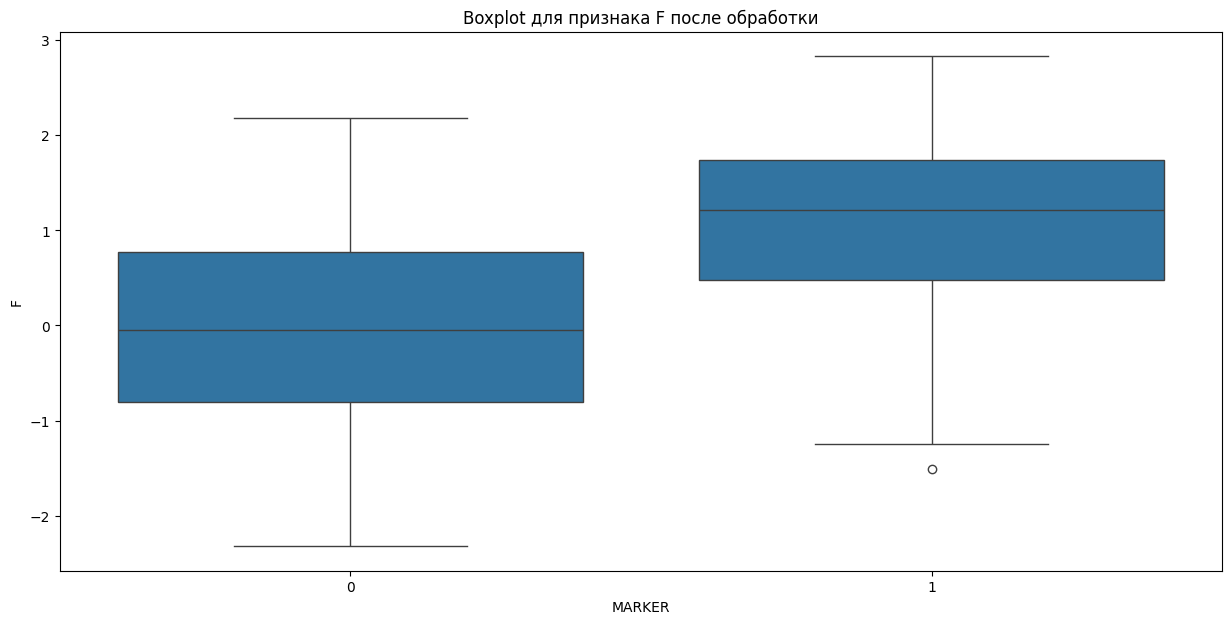

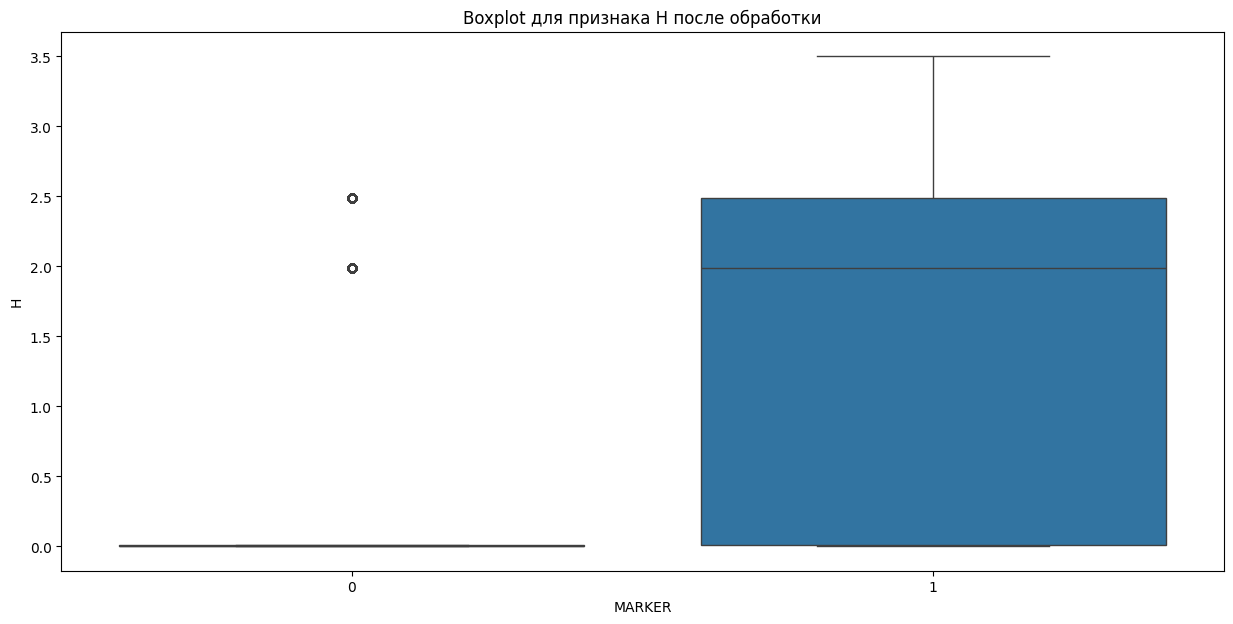

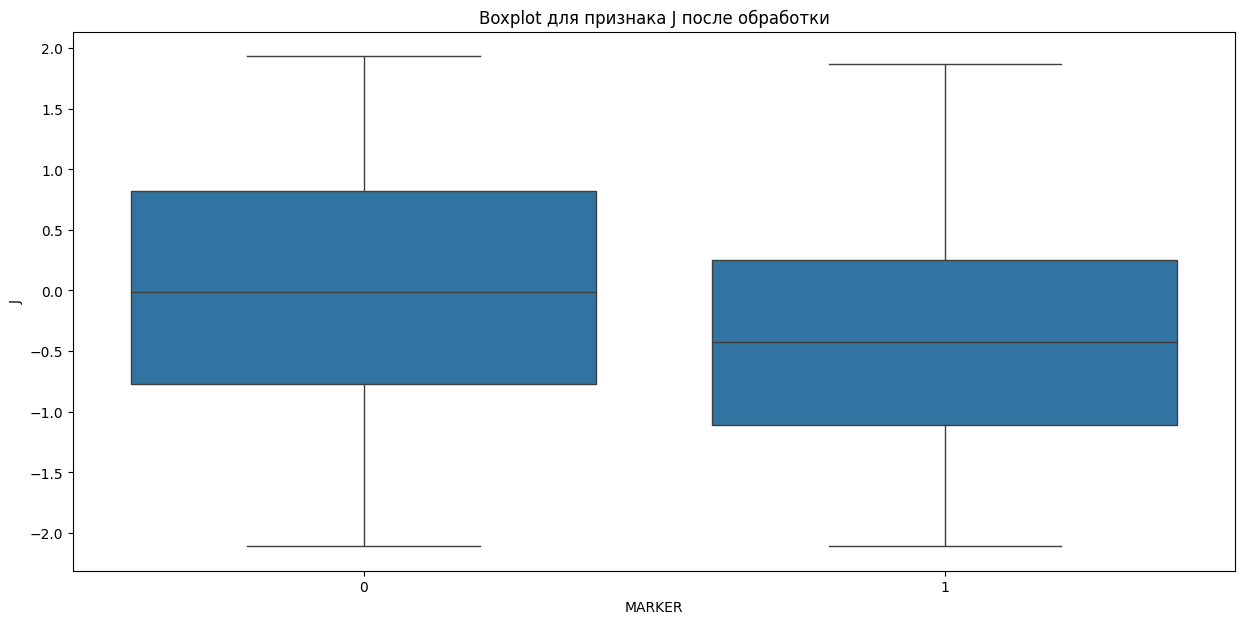

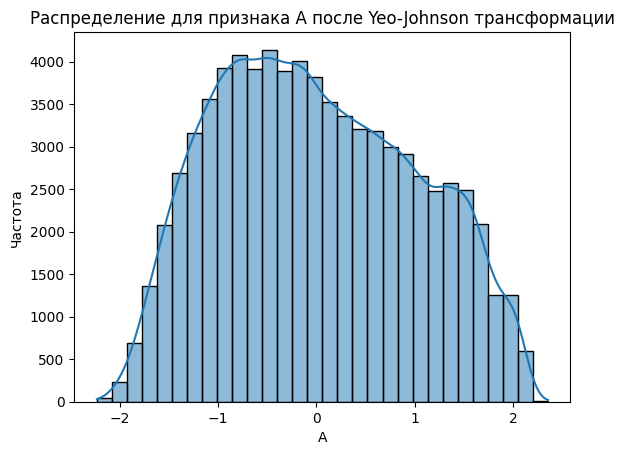

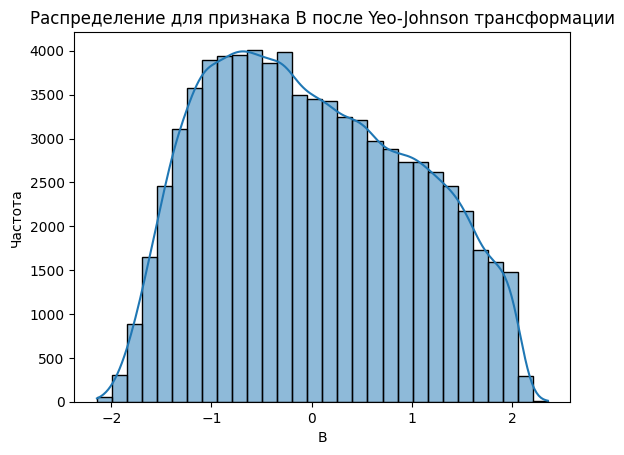

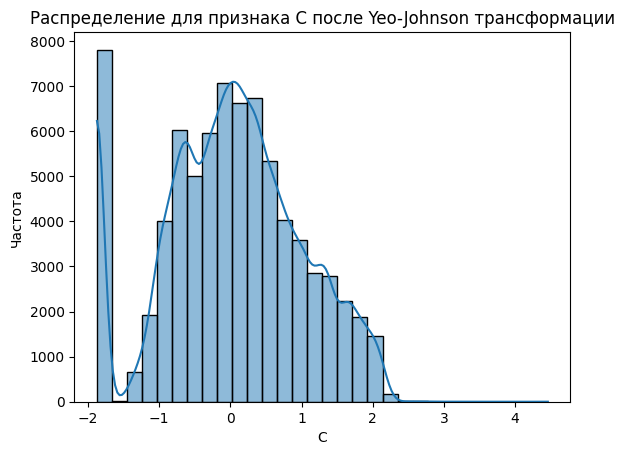

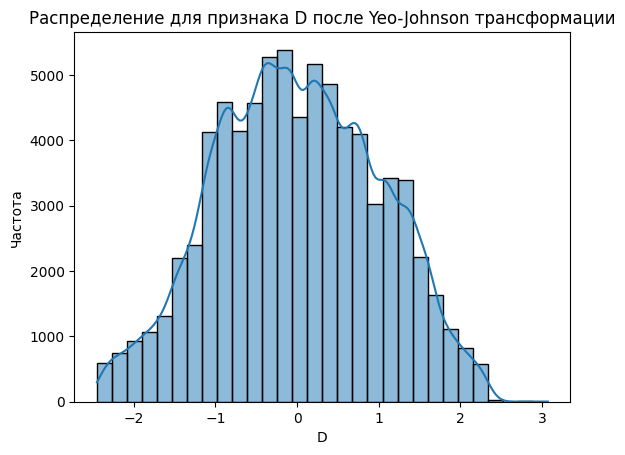

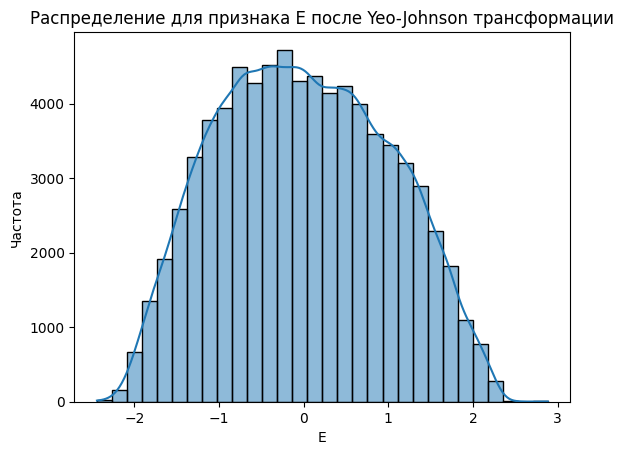

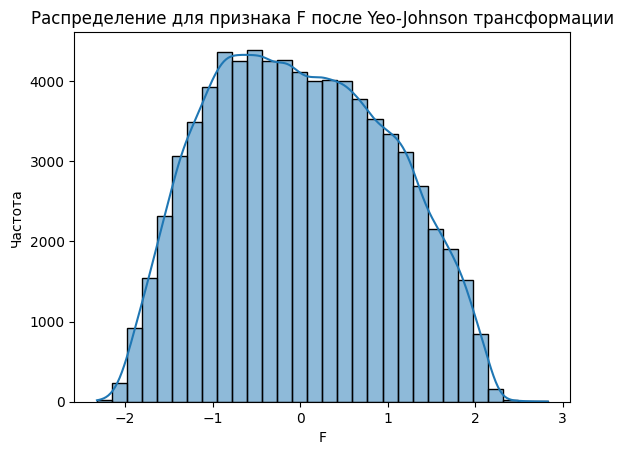

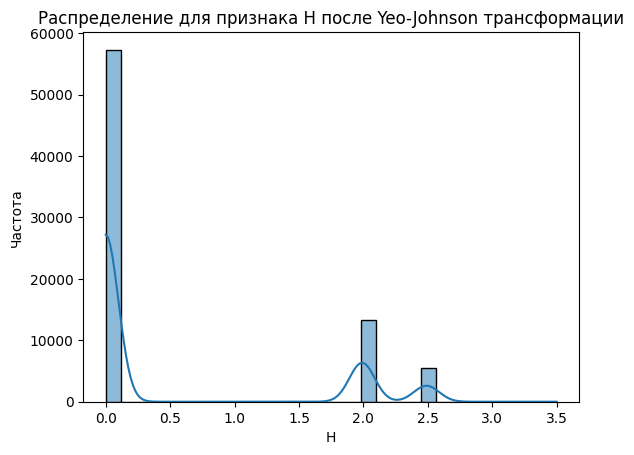

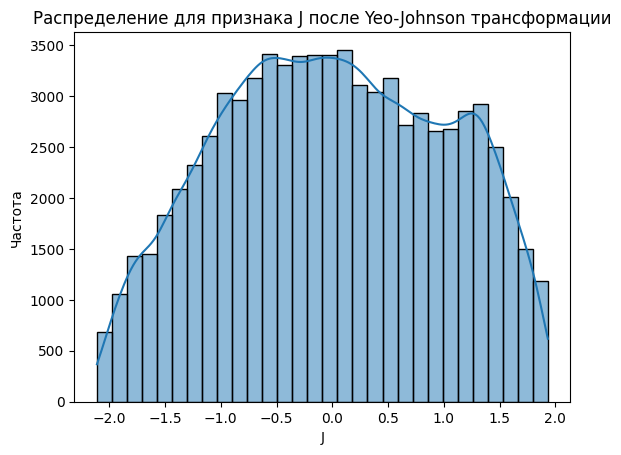

In [16]:
for column in num_columns:
    plt.figure(figsize=(15, 7))
    sns.boxplot(x="MARKER", y=column, data=df_transformed)
    plt.title(f"Boxplot для признака {column} после обработки")
    plt.xlabel("MARKER")
    plt.ylabel(column)
    plt.show()

for column in num_columns:
    sns.histplot(df_transformed[column], kde=True, bins=30)
    plt.title(f'Распределение для признака {column} после Yeo-Johnson трансформации')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

Исследование зависимости между данных(просмотр корреляции)


<ipython-input-17-9d9badf66963>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.loc[:, 'y'] = y


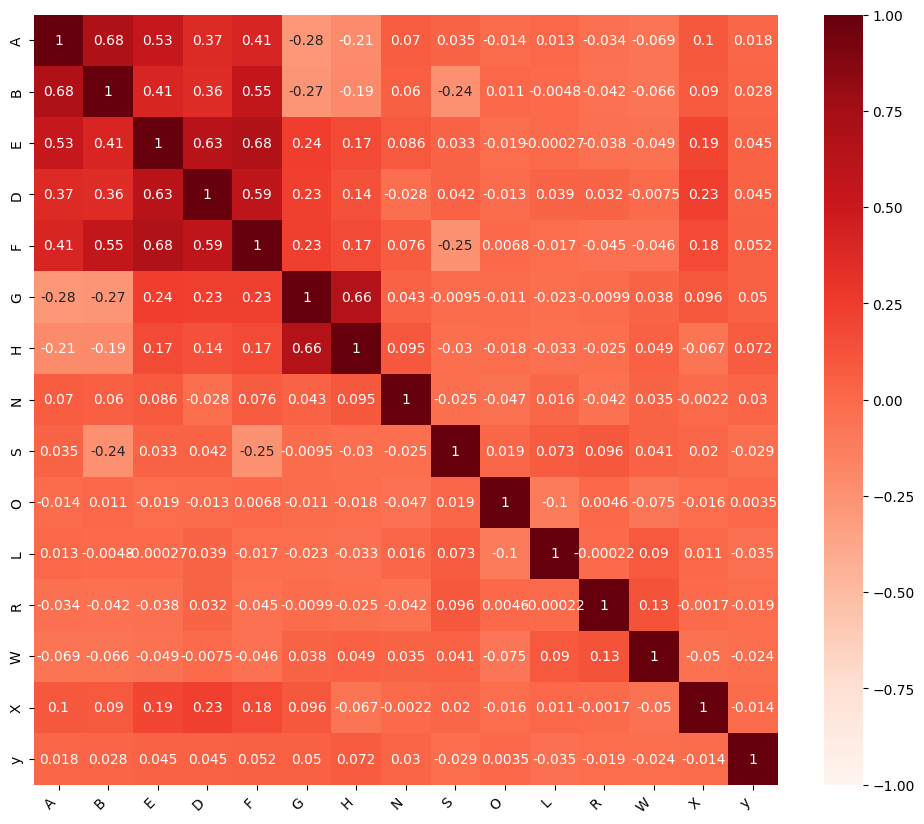

In [17]:
y = df_transformed['MARKER']
df_c = df_transformed[
    ['A', 'B', 'E', 'D', 'F', 'G', 'H', 'N', 'S', 'O', 'L', 'R', 'W', 'X']
  ]
df_c.loc[:, 'y'] = y


plt.figure(figsize = (12,10))

cor = df_c.corr(method = 'kendall')

ax = sns.heatmap(cor,
                 annot = True,
                 vmin = -1,
                 vmax = 1,
                 center = 0,
                 cmap = plt.cm.Reds)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 45,
                   horizontalalignment = 'right')

plt.show()

Наблюдается зависимость между даннымистолбцов А и В,G и H, а также F,E,D. С целевой переменной нет сильной зависимости ни одного из представленных столбцов данных

Проверка мультиколлинеарности

In [18]:
mult_c = df_transformed[
    ['A','D','F', 'G', 'H','N','S','O','L','R', 'W', 'X'
    ]
  ]

mult_c.loc[:, 'Intercept'] = 1


vif = pd.DataFrame()
vif['variables'] = mult_c.columns
vif['VIF'] = [variance_inflation_factor(mult_c.values, i) for i in range(mult_c.shape[1])]

vif

<ipython-input-18-0a1df220c898>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_c.loc[:, 'Intercept'] = 1


,variables,VIF
0,A,4.563592
1,D,4.082267
2,F,6.438586
3,G,4.528711
4,H,1.971634
5,N,1.087040
6,S,1.772637
7,O,1.047838
8,L,1.033733
9,R,1.049850


Были проверены также другие варианты данных, но при добавлении столбцов B, E наблюдается слишком высокая мультиколлинеарность, поэтому их не будем включать в выборку необходимых столбцов для обучения модели

Исследование наиболее важных признаков для модели с помощью случайного леса

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sc = StandardScaler()
X_train[num_columns] = sc.fit_transform(X_train[num_columns])
X_test[num_columns] = sc.transform(X_test[num_columns])

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [122]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train_balanced, y_train_balanced)

y_pred = model.predict(X_test)
print("Отчет по классификации:\n", classification_report(y_test, y_pred))


Отчет по классификации:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22747
           1       0.09      0.05      0.07       111

    accuracy                           0.99     22858
   macro avg       0.54      0.53      0.53     22858
weighted avg       0.99      0.99      0.99     22858



<ipython-input-123-35cca6061741>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


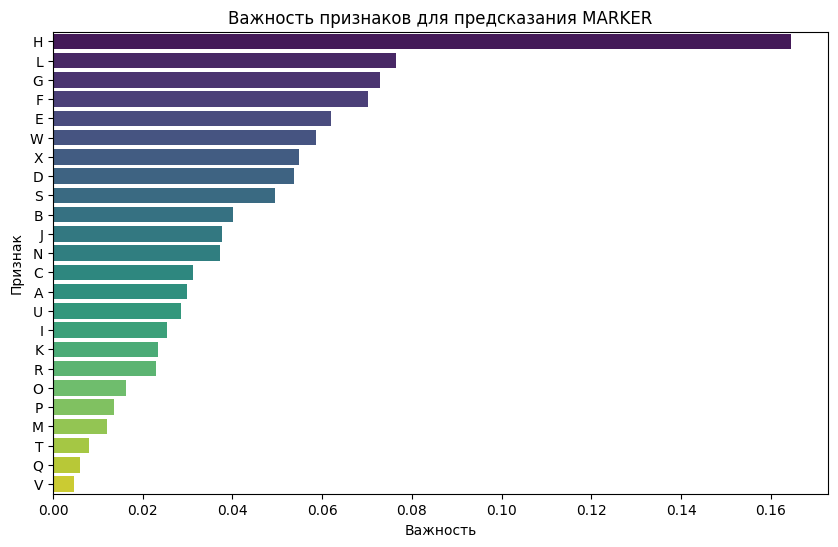

In [123]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Важность признаков для предсказания MARKER')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Видно, что нет данных, которые ощутимо влияют на целевую переменную

Выбор более значимых столбцов для дальнейшего обучения модели. Выбор был сделан на основании значимых значений, полученных выше, а также учитывая коллинеарность и мультиколлинеарность, а также при просмотров графиков боксплотов, замечая большее или меньшее различие данных между классами

In [28]:
selected_columns = ['A', 'D','F', 'H','G', 'N', 'S', 'O', 'L','X', 'W']

X = df_transformed.drop(columns=['ID', 'MARKER'])
X_selected = X[selected_columns]
X_selected.head()
y = df_transformed['MARKER']
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Обучение модели xgboost для решения задачи бинарной классификации данных. Найдем наилучшие гиперпараметры для наилучшей точности

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [154]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=kfold,
                           n_jobs=-1,
                           verbose=1)

In [155]:
grid_search.fit(X_train, y_train)

print(f"Лучшие гиперпараметры: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC: {roc_auc:.4f}")

cross_val_scores = cross_val_score(best_model, X_test, y_test, cv=kfold, scoring='roc_auc')
print(f"Средний F1 Score: {cross_val_scores.mean():.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие гиперпараметры: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22747
           1       1.00      0.14      0.25       111

    accuracy                           1.00     22858
   macro avg       1.00      0.57      0.62     22858
weighted avg       1.00      1.00      0.99     22858

ROC AUC: 0.9100
Средний F1 Score: 0.8830


Обучение модели логистической регрессии для решения задачи бинарной классификации. Найдем наилучшие гиперпараметры, в особенности весовую функцию, так как в данных наблюдается сильный дисбаланс

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [{0: 1, 1: w} for w in [5, 10, 15, 20]]
}

logreg = LogisticRegression(solver='liblinear', random_state=42)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=logreg,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=kfold,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
log_model = grid_search.best_estimator_

print("Лучшие гиперпараметры:", best_params)

y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие гиперпараметры: {'C': 10, 'class_weight': {0: 1, 1: 20}}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15171
           1       0.09      0.26      0.14        68

    accuracy                           0.98     15239
   macro avg       0.54      0.63      0.56     15239
weighted avg       0.99      0.98      0.99     15239

ROC AUC Score: 0.9299


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


Обучение модели градиентного бустинга(catboost) для решения задачи бинарной классификации. Модели градиентного бустинга более устойчивы к дисбалансу классов


In [29]:
from catboost import CatBoostClassifier


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


catboost_model = CatBoostClassifier(eval_metric='AUC', random_seed=42, verbose=0)

param_grid_catboost = {
'depth': [4, 6, 8],
'learning_rate': [0.01, 0.05, 0.1],
'iterations': [100, 200],
'subsample': [0.8, 1.0],
'class_weights': [{0: 1, 1: w} for w in [10, 20, 50, 100]]
}

grid_search_catboost = GridSearchCV(estimator=catboost_model,
param_grid=param_grid_catboost,
scoring='roc_auc',
cv=kfold,
n_jobs=-1,
verbose=1)

grid_search_catboost.fit(X_train, y_train)

print(f"Лучшие гиперпараметры CatBoost: {grid_search_catboost.best_params_}")
best_model_catboost = grid_search_catboost.best_estimator_
y_pred_catboost = best_model_catboost.predict(X_test)
y_pred_proba_catboost = best_model_catboost.predict_proba(X_test)[:, 1]


print("Classification Report for CatBoost:")
print(classification_report(y_test, y_pred_catboost))
print(f"ROC AUC Score for CatBoost: {roc_auc_score(y_test, y_pred_proba_catboost):.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Лучшие гиперпараметры CatBoost: {'class_weights': {0: 1, 1: 10}, 'depth': 4, 'iterations': 100, 'learning_rate': 0.1, 'subsample': 0.8}
Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22747
           1       0.38      0.26      0.31       111

    accuracy                           0.99     22858
   macro avg       0.69      0.63      0.65     22858
weighted avg       0.99      0.99      0.99     22858

ROC AUC Score for CatBoost: 0.9135


Составляем модель с наилучшими параметрами


In [31]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

catboost_model = CatBoostClassifier(
    depth=4,
    learning_rate=0.1,
    iterations=100,
    subsample=0.8,
    class_weights={0: 1, 1: 10},
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

print("Classification Report for CatBoost:")
print(classification_report(y_test, y_pred_catboost))
print(f"ROC AUC Score for CatBoost: {roc_auc_score(y_test, y_pred_proba_catboost):.4f}")


Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22747
           1       0.38      0.26      0.31       111

    accuracy                           0.99     22858
   macro avg       0.69      0.63      0.65     22858
weighted avg       0.99      0.99      0.99     22858

ROC AUC Score for CatBoost: 0.9135


Обучение модели случайного леса для решения задачи бинарной классификации. Она также более устойчива к не сбалансированным данным


In [131]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   scoring='roc_auc',
                                   cv=kfold,
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=42)

random_search.fit(X_train, y_train)

print(f"Лучшие гиперпараметры: {random_search.best_params_}")

rand_tree = random_search.best_estimator_
y_pred =rand_tree.predict(X_test)
y_pred_proba = rand_tree.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     22747
           1       0.06      0.42      0.11       111

    accuracy                           0.97     22858
   macro avg       0.53      0.70      0.55     22858
weighted avg       0.99      0.97      0.98     22858

ROC AUC Score: 0.8915


Главное внимание во всех моделях обратим на метрики ROC AUC и F1-score, а также precision, recall, Accuracy в данном случае не дает видимой оценки из-за большого дисбаланса классов. Во всех моделях видно, что для класса 1 модели работают недостаточно хорошо из-за большого дисбаланса и маленькой выборки данного класса. В будущем можно попробовать также генерировать синтетические данные и искусственно увеличивать выборку до большего баланса, либо уменьшить больший класс. Было проверено на некоторых моделях, но весомых улучшений не дало.

Лучшие показатели F1-score, ROC AUC у модели catboost, поэтому будет использовать ее для оценки качества модели на тестовой выборке

In [32]:
df_test = pd.read_excel('Test.xlsb')

df_test.reset_index(drop=True, inplace=True)



In [33]:
X_test = df_test.drop(columns=['ID', 'MARKER'])
y_test = df_test['MARKER']


num_columns = X_selected.select_dtypes(include=['float64']).columns.tolist()
if 'G' in X_selected.columns:
    num_columns.append('G')

pt = PowerTransformer(method='yeo-johnson')
for column in num_columns:
    if column not in ['G', 'H']:
        X_test[column] = pt.fit_transform(X_test[[column]])

object_columns = X_test.select_dtypes(include=['object']).columns
for column in object_columns:
    labelencoder = LabelEncoder()
    X_test[column] = labelencoder.fit_transform(X_test[column])
X_test = X_test[selected_columns]
sc1 =  StandardScaler()
X_selected[num_columns] = sc1.fit_transform(X_selected[num_columns])
X_test[num_columns] = sc1.transform(X_test[num_columns])
X_test = pd.DataFrame(X_test, columns=selected_columns)

X_test.head()


<ipython-input-33-a2f7bdeec46b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected[num_columns] = sc1.fit_transform(X_selected[num_columns])
<ipython-input-33-a2f7bdeec46b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[num_columns] = sc1.transform(X_test[num_columns])


,A,D,F,H,G,N,S,O,L,X,W
0,-0.521229,-0.533836,0.556611,3.187050,1.147291,3,0,3,13,0,0
1,0.823953,1.255445,0.920887,3.187050,1.147291,3,4,2,48,0,0
2,-1.106517,-0.035389,-0.025445,1.572246,1.147291,3,3,2,180,0,0
3,-1.267065,-1.034365,-0.470120,3.187050,1.147291,3,3,2,12,0,1
4,0.873765,1.414564,1.468260,3.187050,1.147291,0,4,2,48,0,0


In [35]:
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

print("Classification Report for CatBoost:")
print(classification_report(y_test, y_pred_catboost))
print(f"ROC AUC Score for CatBoost: {roc_auc_score(y_test, y_pred_proba_catboost):.4f}")

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     38259
           1       0.04      0.14      0.07       146

    accuracy                           0.99     38405
   macro avg       0.52      0.56      0.53     38405
weighted avg       0.99      0.99      0.99     38405

ROC AUC Score for CatBoost: 0.8653


Ксожалению, модель показывала не очень хорошую точность на тренировочных данных, на тестовых она показала плохие результаты на тестовой выборке по классу 1, это связано с дисбалансом классов стоит попробовать другие методы обработки или обучения данных, так как данная модель имеет не лучшие показатели. Также можно попробовать выбрать другие параметры для обучения моделей. Вообще, для бизнеса лучше использовать интерпретируемую модель, как логистическая регрессия, поэтому лучшим способом будет нахождение таких гиперпараметров для логистической регрессии, с которыми модель будет иметь высокую точность
